In [4]:
%matplotlib inline

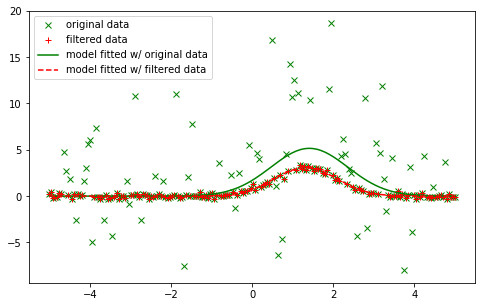

In [5]:
import numpy as np
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting
import scipy.stats as stats
from matplotlib import pyplot as plt

# Generate fake data with outliers
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
c = stats.bernoulli.rvs(0.35, size=x.shape)
y += (np.random.normal(0., 0.2, x.shape) +
      c*np.random.normal(3.0, 5.0, x.shape))
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)

# initialize fitters
fit = fitting.LevMarLSQFitter()
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip,
                                           niter=3, sigma=3.0)

# get fitted model and filtered data
filtered_data, or_fitted_model = or_fit(g_init, x, y)
fitted_model = fit(g_init, x, y)

# plot data and fitted models
plt.figure(figsize=(8,5))
plt.plot(x, y, 'gx', label="original data")
plt.plot(x, filtered_data, 'r+', label="filtered data")
plt.plot(x, fitted_model(x), 'g-',
         label="model fitted w/ original data")
plt.plot(x, or_fitted_model(x), 'r--',
         label="model fitted w/ filtered data")
plt.legend(loc=2, numpoints=1)

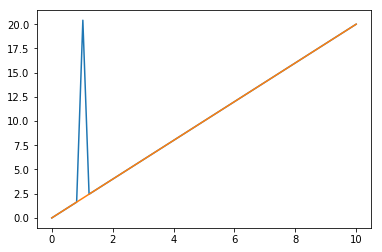

In [7]:
x = np.linspace(0, 10)
y = 2*x 
y[5] *= 10

polynomial = models.Polynomial1D(degree=1)
fit = fitting.LevMarLSQFitter()
outliersRemoved_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip)

filtered_data, model = outliersRemoved_fit(polynomial, x, y)

plt.plot(x,y,x,model(x))

In [19]:
import numpy as np
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting
import scipy.stats as stats
from matplotlib import pyplot as plt

# Generate fake data with outliers
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
c = stats.bernoulli.rvs(0.35, size=x.shape)
y += (np.random.normal(0., 0.2, x.shape) +
      c*np.random.normal(3.0, 5.0, x.shape))
y_uncs = np.sqrt(np.square(np.full(x.shape, 0.2))
                 + c*np.square(np.full(x.shape,5.0)))
g_init = models.Polynomial1D(degree=1)

# initialize fitters
fit = fitting.LevMarLSQFitter()

# fit the data w/o weights
fitted_model = fit(g_init, x, y)

# fit the data using the uncertainties as weights
fitted_model_weights = fit(g_init, x, y, weights=1.0/y_uncs)

# plot data and fitted models
plt.figure(figsize=(8,5))
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
plt.plot(x, fitted_model(x), 'g-', linewidth=4.0,
         label="model fitted w/o weights")
plt.plot(x, fitted_model_weights(x), 'r--', linewidth=4.0,
         label="model fitted w/ weights")
plt.legend(loc=2, numpoints=1)

ValueError: operands could not be broadcast together with shapes (200,) (200,2) 

In [9]:
y_uncs.shape

(200,)

In [10]:
x.shape

(200,)

In [11]:
xdata = np.array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
       234, 235, 236, 237, 238, 239, 270, 271, 272, 273, 274, 275, 276,
       277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289,
       290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302,
       303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315,
       316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328,
       329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341,
       342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354,
       355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367,
       368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
       381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
       394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406,
       407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419,
       420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432,
       433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445,
       446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458,
       459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471,
       472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484,
       485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497,
       498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510,
       511])

In [12]:
ydata = np.array([ 208.1821 ,  198.39273,  198.27849,  206.23642,  201.24557,
        196.78555,  200.82509,  197.47318,  200.59746,  205.372  ,
        197.09218,  196.79007,  205.74722,  199.14484,  202.14836,
        203.78859,  203.25996,  200.56212,  203.80531,  203.1801 ,
        201.7561 ,  206.57292,  205.9636 ,  202.07329,  206.2242 ,
        201.9842 ,  196.83606,  210.4873 ,  200.26561,  199.9003 ,
        204.18936,  200.06207,  197.28026,  202.70364,  202.7467 ,
        199.67143,  200.07518,  207.85193,  195.68068,  201.46681,
        203.94186,  193.32768,  200.38138,  200.01712,  195.20834,
        197.3782 ,  206.87283,  202.04361,  201.2359 ,  199.81894,
        194.76884,  195.02635,  202.42403,  197.75835,  193.90504,
        195.88425,  211.17749,  192.7037 ,  194.1871 ,  201.96968,
        201.76645,  192.50893,  199.07944,  192.16292,  196.86497,
        196.71167,  204.76689,  204.5792 ,  191.46013,  196.18681,
        197.77017,  200.23997,  193.00676,  203.30551,  202.98691,
        202.09549,  201.78036,  200.56345,  197.23074,  193.741  ,
        202.69499,  196.28084,  208.19418,  200.01437,  198.62361,
        200.68552,  211.47737,  200.46532,  201.80838,  202.07297,
        202.10153,  199.09962,  196.33679,  200.46689,  196.27109,
        193.45528,  201.44653,  196.72916,  204.42259,  205.77866,
        201.04553,  197.47916,  206.05307,  195.00888,  199.3769 ,
        201.92096,  203.755  ,  204.24127,  209.5112 ,  194.20676,
        199.12852,  201.87843,  199.92282,  199.48323,  200.97313,
        200.84154,  206.77693,  200.9516 ,  203.15366,  199.74806,
        199.57733,  200.33502,  197.76755,  198.9794 ,  202.20326,
        200.26291,  209.4365 ,  198.20264,  195.87317,  197.38512,
        196.85294,  195.96301,  195.93335,  203.0846 ,  194.49081,
        203.0531 ,  201.37283,  201.9531 ,  202.48788,  204.0279 ,
        198.7156 ,  198.88046,  199.4261 ,  187.99231,  204.25607,
        192.26208,  197.42241,  201.00984,  205.86465,  201.70993,
        194.10788,  206.20296,  193.93102,  207.62167,  196.04172,
        197.27866,  196.85329,  195.96718,  194.97144,  198.95201,
        198.59346,  197.80013,  196.28748,  205.19511,  201.07185,
        197.71255,  201.6799 ,  198.70676,  204.40811,  194.19351,
        204.29375,  193.89258,  201.86194,  200.34549,  194.37741,
        200.50996,  206.64209,  197.10883,  205.76689,  194.44391,
        199.14613,  198.45552,  195.90877,  196.80933,  197.62314,
        200.78847,  204.95918,  201.5433 ,  203.36172,  207.30612,
        201.35889,  203.71065,  203.75996,  196.90945,  200.25748,
        206.93478,  200.58574,  194.87544,  198.49258,  203.39723,
        208.13655,  205.51567,  193.89749,  202.08041,  198.147  ,
        192.28653,  204.73871,  201.34952,  210.92009,  200.05702,
        196.81593,  204.15723,  199.18552,  209.37393,  202.2832 ,
        199.3191 ,  202.16202,  205.00333,  198.95688,  194.98373,
        202.97992,  200.50822,  203.78116,  204.59996,  198.84322,
        206.47116,  201.48491,  191.73941,  200.96631,  195.65933,
        205.9146 ,  204.5455 ,  191.07611,  200.22458,  203.31834,
        199.55193,  201.06021,  205.4076 ,  197.11606,  205.16577,
        199.48659,  206.75732,  196.4683 ,  189.45299,  198.15598,
        208.20996,  191.69748,  201.84749,  199.2856 ,  197.90111,
        209.37383,  201.7599 ,  197.94127,  200.72049,  199.53018,
        201.9172 ,  200.17659,  190.74905,  195.09647,  192.46323,
        205.096  ,  204.29556,  203.167  ,  205.20332,  197.32866,
        200.15372,  201.86302,  201.81   ,  195.90082,  194.46844,
        197.95381,  200.49144,  207.72571,  200.83366,  198.841  ,
        208.1409 ,  204.33005,  194.79483,  204.96164,  200.49057,
        194.04852,  198.88953,  196.5029 ,  198.46632,  204.36661,
        207.17972,  194.09128,  198.52094,  197.6843 ,  206.02563,
        197.86572,  189.16069,  196.17183,  200.08066,  203.51529,
        202.16367,  199.61832,  194.22914,  195.33261,  198.59906,
        199.30379,  196.57596,  209.00874,  207.27898,  199.22842,
        197.90039,  200.32907,  200.67702,  198.28152,  195.5197 ,
        203.19783,  194.40489,  192.57234,  192.94589,  201.96103,
        203.06642,  201.48251,  204.43066,  194.63126,  193.69006,
        201.87465,  207.60379,  207.29646,  193.879  ,  208.14322,
        202.42813,  195.54376,  202.56416,  197.1782 ,  200.10059,
        207.84319,  198.59988,  203.24388,  203.2293 ,  205.40292,
        196.56625,  205.54634,  197.53969,  196.48846,  208.21419,
        198.39438,  199.15074,  204.83572,  200.29105,  201.50734,
        204.12897,  192.43703,  197.8836 ,  198.00171,  205.44019,
        200.02107,  205.80283,  203.68112,  206.78671,  202.54733,
        201.45708,  195.72697,  209.14824,  199.12091,  199.1077 ,
        196.49344,  200.1594 ,  199.3208 ,  199.60373,  192.3801 ,
        193.1014 ,  204.3519 ,  201.52594,  199.5242 ,  192.62828,
        201.95444,  198.07806,  202.69774,  201.7909 ,  200.43661,
        199.67453,  194.94966,  201.2763 ,  199.09288,  200.17801,
        195.04123,  209.56607,  194.67099,  195.78032,  200.74252,
        198.80917,  197.71558,  196.72308,  201.56184,  198.43929,
        205.17459,  195.70988,  202.23605,  193.50192,  199.67969,
        202.15268,  196.1201 ,  197.65636,  201.6348 ,  199.78188,
        204.997  ,  195.90666,  201.97229,  204.78366,  197.5574 ,
        200.37685,  198.28667,  201.8193 ,  204.82014,  206.1221 ,
        197.62216,  190.54076,  197.977  ,  198.60692,  205.32658,
        206.28777,  206.70456,  205.18047,  187.5423 ,  198.0669 ,
        198.50795,  199.25856,  197.23502,  201.8295 ,  200.3341 ,
        199.68762,  204.16214,  201.82188,  187.77522,  199.74115,
        204.18988,  198.14746,  199.89642,  200.72507,  201.70667,
        195.84344,  199.85675,  206.53374,  201.68622,  197.13098,
        194.21715,  199.7384 ,  208.39775,  200.54193,  196.11185,
        202.8178 ,  200.68289,  202.12976,  199.24297,  202.04668,
        196.18042,  195.89157,  193.85286,  196.149  , 1559.853  ,
        202.14755,  197.66092,  202.63773,  200.00618,  198.31595,
        195.21547,  197.1445 ,  202.07248,  196.46286,  202.54865,
        199.34605,  194.97316,  197.95819,  200.70834,  201.27449,
        194.00479,  197.11855,  197.09549,  191.59792,  203.34308,
        195.20634,  202.2    ,  195.55591,  196.28276,  203.01755,
        203.62874,  207.6182 ])

In [13]:
variance = np.array([ 21.81821 ,  20.839273,  20.827848,  21.623642,  21.124557,
        20.678555,  21.082508,  20.747318,  21.059746,  21.537199,
        20.709217,  20.679007,  21.574722,  20.914484,  21.214836,
        21.378859,  21.325996,  21.056211,  21.380531,  21.31801 ,
        21.17561 ,  21.657291,  21.59636 ,  21.207329,  21.62242 ,
        21.198421,  20.683605,  22.04873 ,  21.026562,  20.99003 ,
        21.418936,  21.006207,  20.728025,  21.270365,  21.27467 ,
        20.967144,  21.007519,  21.785192,  20.568068,  21.14668 ,
        21.394186,  20.332767,  21.038137,  21.001713,  20.520834,
        20.73782 ,  21.687283,  21.204361,  21.12359 ,  20.981894,
        20.476885,  20.502636,  21.242403,  20.775835,  20.390505,
        20.588425,  22.117748,  20.27037 ,  20.41871 ,  21.196968,
        21.176645,  20.250893,  20.907944,  20.216291,  20.686497,
        20.671167,  21.476688,  21.45792 ,  20.146013,  20.618681,
        20.777018,  21.023998,  20.300676,  21.330551,  21.29869 ,
        21.209549,  21.178036,  21.056345,  20.723074,  20.3741  ,
        21.269499,  20.628084,  21.819418,  21.001438,  20.862362,
        21.068552,  22.147738,  21.046532,  21.180838,  21.207296,
        21.210154,  20.909962,  20.633678,  21.046688,  20.62711 ,
        20.345528,  21.144653,  20.672916,  21.442259,  21.577866,
        21.104553,  20.747915,  21.605307,  20.500889,  20.93769 ,
        21.192097,  21.3755  ,  21.424128,  21.95112 ,  20.420675,
        20.912853,  21.187843,  20.992283,  20.948322,  21.097313,
        21.084154,  21.677692,  21.09516 ,  21.315365,  20.974806,
        20.957733,  21.033503,  20.776754,  20.89794 ,  21.220325,
        21.02629 ,  21.94365 ,  20.820263,  20.587317,  20.738512,
        20.685293,  20.596302,  20.593334,  21.30846 ,  20.449081,
        21.30531 ,  21.137283,  21.195309,  21.248789,  21.40279 ,
        20.871561,  20.888046,  20.94261 ,  19.79923 ,  21.425608,
        20.226208,  20.74224 ,  21.100985,  21.586466,  21.170994,
        20.410788,  21.620296,  20.3931  ,  21.762167,  20.604172,
        20.727865,  20.68533 ,  20.596718,  20.497143,  20.8952  ,
        20.859346,  20.780012,  20.628748,  21.519512,  21.107185,
        20.771255,  21.16799 ,  20.870676,  21.440811,  20.419352,
        21.429375,  20.389257,  21.186193,  21.03455 ,  20.43774 ,
        21.050997,  21.66421 ,  20.710882,  21.576689,  20.444391,
        20.914614,  20.845552,  20.590878,  20.680933,  20.762314,
        21.078846,  21.495918,  21.154331,  21.336172,  21.730612,
        21.13589 ,  21.371065,  21.375996,  20.690945,  21.025747,
        21.693478,  21.058575,  20.487545,  20.849258,  21.339724,
        21.813656,  21.551567,  20.38975 ,  21.208042,  20.814701,
        20.228653,  21.473871,  21.134953,  22.092009,  21.005703,
        20.681593,  21.415722,  20.918552,  21.937393,  21.228321,
        20.931911,  21.216202,  21.500332,  20.895687,  20.498373,
        21.297993,  21.050823,  21.378117,  21.459995,  20.884321,
        21.647116,  21.14849 ,  20.17394 ,  21.09663 ,  20.565933,
        21.59146 ,  21.45455 ,  20.10761 ,  21.022457,  21.331835,
        20.955193,  21.106022,  21.54076 ,  20.711605,  21.516577,
        20.948658,  21.675732,  20.646832,  19.9453  ,  20.815598,
        21.820995,  20.169748,  21.18475 ,  20.92856 ,  20.790112,
        21.937382,  21.175991,  20.794127,  21.072048,  20.953018,
        21.191721,  21.017658,  20.074905,  20.509647,  20.246323,
        21.5096  ,  21.429556,  21.3167  ,  21.520332,  20.732866,
        21.015371,  21.186302,  21.181   ,  20.590082,  20.446844,
        20.795382,  21.049145,  21.772572,  21.083366,  20.8841  ,
        21.81409 ,  21.433004,  20.479483,  21.496164,  21.049057,
        20.404852,  20.888952,  20.65029 ,  20.846632,  21.43666 ,
        21.717972,  20.409128,  20.852093,  20.768429,  21.602564,
        20.786572,  19.916069,  20.617184,  21.008066,  21.351528,
        21.216366,  20.961832,  20.422915,  20.53326 ,  20.859905,
        20.930378,  20.657597,  21.900875,  21.727898,  20.922842,
        20.79004 ,  21.032907,  21.067701,  20.828152,  20.55197 ,
        21.319782,  20.440489,  20.257235,  20.29459 ,  21.196102,
        21.306643,  21.14825 ,  21.443066,  20.463125,  20.369007,
        21.187466,  21.76038 ,  21.729647,  20.3879  ,  21.814322,
        21.242813,  20.554377,  21.256416,  20.717821,  21.01006 ,
        21.784319,  20.85999 ,  21.324389,  21.32293 ,  21.540293,
        20.656626,  21.554634,  20.75397 ,  20.648846,  21.821419,
        20.839437,  20.915073,  21.483572,  21.029104,  21.150734,
        21.412897,  20.243702,  20.78836 ,  20.80017 ,  21.544018,
        21.002108,  21.580282,  21.368113,  21.67867 ,  21.254734,
        21.145708,  20.572697,  21.914824,  20.91209 ,  20.91077 ,
        20.649343,  21.01594 ,  20.93208 ,  20.960373,  20.23801 ,
        20.310139,  21.43519 ,  21.152594,  20.95242 ,  20.262829,
        21.195444,  20.807806,  21.269773,  21.179089,  21.043661,
        20.967453,  20.494967,  21.12763 ,  20.909288,  21.017801,
        20.504124,  21.956608,  20.467098,  20.578032,  21.074253,
        20.880917,  20.771557,  20.672308,  21.156185,  20.84393 ,
        21.51746 ,  20.570988,  21.223606,  20.350193,  20.967968,
        21.215267,  20.612011,  20.765636,  21.163479,  20.978188,
        21.499699,  20.590666,  21.19723 ,  21.478367,  20.755741,
        21.037685,  20.828667,  21.18193 ,  21.482014,  21.61221 ,
        20.762217,  20.054075,  20.7977  ,  20.860691,  21.532658,
        21.628777,  21.670456,  21.518047,  19.75423 ,  20.80669 ,
        20.850796,  20.925856,  20.723501,  21.18295 ,  21.033411,
        20.968761,  21.416214,  21.182188,  19.777523,  20.974115,
        21.418987,  20.814747,  20.989643,  21.072506,  21.170666,
        20.584345,  20.985676,  21.653374,  21.168621,  20.713099,
        20.421715,  20.97384 ,  21.839775,  21.054193,  20.611185,
        21.28178 ,  21.068289,  21.212976,  20.924297,  21.204668,
        20.618042,  20.589157,  20.385286,  20.6149  , 156.9853  ,
        21.214756,  20.766092,  21.263773,  21.000618,  20.831594,
        20.521547,  20.71445 ,  21.207249,  20.646286,  21.254864,
        20.934605,  20.497316,  20.795818,  21.070835,  21.127449,
        20.400478,  20.711855,  20.709549,  20.159792,  21.334309,
        20.520634,  21.22    ,  20.555592,  20.628277,  21.301754,
        21.362873,  21.76182 ])

In [15]:
polynomial = models.Polynomial1D(degree=1)
fit = fitting.LevMarLSQFitter()
outliersRemoved_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip)

a, b = fit(polynomial, xdata, ydata, weights=1.0 / variance)
filtered_data, model = outliersRemoved_fit(polynomial, xdata, ydata, weights = variance)

ValueError: operands could not be broadcast together with shapes (482,) (482,2) 

In [17]:
x = xdata
y = ydata
y_uncs = variance
g_init = models.Polynomial1D(degree=4)

# initialize fitters
fit = fitting.LevMarLSQFitter()

# fit the data w/o weights
fitted_model = fit(g_init, x, y)

# fit the data using the uncertainties as weights
fitted_model_weights = fit(g_init, x, y, weights=1.0/y_uncs)

# plot data and fitted models
plt.figure(figsize=(8,5))
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
plt.plot(x, fitted_model(x), 'g-', linewidth=4.0,
         label="model fitted w/o weights")
plt.plot(x, fitted_model_weights(x), 'r--', linewidth=4.0,
         label="model fitted w/ weights")
plt.legend(loc=2, numpoints=1)

ValueError: operands could not be broadcast together with shapes (482,) (482,5) 